# Social Determinants of Health
## County-Level and Regional Health Analysis
Robert Lusardi

December 2023

# Introduction
* In this presentation, I will be analyzing a dataset containing county-level health, demographic, and economic statistics for every county in the US in order to answer a few questions about factors that impact county-level health
    - Specifically, as a proxy for health, I will be using the provided "Poor.Health" as my y-variable
    - Poor.Health (I will also refer to this as "Health" or the "Health Index") represents the proportion of a given county that has poor health status. The higher the figure, the less healthy the population of the county is
* There's a ton of data -- 2715 counties and 25 statistics are tracked, so it's hard to know where to even begin
* So, to inform what questions we want to ask, let's examine the data!

In [1]:
#basic importing stuff
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import os

county_data = pd.read_csv("/Users/robertlusardi/Desktop/DataProjects/Social_Determinants_Dec_2023/County_Health_Data_Clean.csv",
                          index_col='Row.Label')
# county_data.info()

First, let's take a quick look at our y-variable, the Poor Health index.

It looks like there are 2715 counties, the median / mean county has 16.7%  / 17.4% of its residents in poor health, respectively, and the data has a meaningfully longer right-tail than left-tail

In [2]:
round(county_data.describe()['Poor.Health'].reset_index(),3)

,index,Poor.Health
0,count,2715.000
1,mean,0.174
2,std,0.045
3,min,0.083
4,25%,0.140
5,50%,0.167
6,75%,0.204
7,max,0.407


Now, let's run and visualize multivariable regression using most of the x-variables, to see which impact Health (note, no bar indicates a coefficient of ~0). It's not perfect - we'll see some things we missed later - but should indicate importance directionally

One question that jumps out: why is Excessive Drinking negatively correlated with Poor Health?

In [3]:
#large multivariable multivariate regression to determine most powerful predictors of health
#code to just run a regression on the columns you care about as determinants of health
formula_string = ""
to_ignore = ["Poor.Health", "Life.Expectancy", "Population","State.FIPS.Code", "County.FIPS.Code", "Five-digit.FIPS.Code", "State.Abbreviation", "CountyName", "Election.Results.2016", "Food.Insecurity.Quintile", "Income.Inequality.Quartile"]
for cols in county_data:
    if cols in to_ignore:
        continue
    else:
        formula_string += 'Q("' + cols + '") + '
formula_string = 'Q("Poor.Health") ~ ' + formula_string
formula_string = formula_string[:-3]

ols_multi = smf.ols(formula=formula_string, data=county_data)
ols_multi = ols_multi.fit()
print(ols_multi.summary())

#extract the coefficients into a dataframe and visualize
multi_coeffs = pd.DataFrame({'coefficients' : ols_multi.params}).reset_index()

#clean the names for printing purposes
multi_coeffs['index'] = multi_coeffs['index'].str.replace('Q','').str.replace('(','').str.replace('\"','').str.replace(')','')
multi_coeffs.rename(columns = {'index' : 'Health Determinant', 'coefficients':'Regression Coefficients'}, inplace=True)

                            OLS Regression Results                            
Dep. Variable:       Q("Poor.Health")   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     917.4
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:27:43   Log-Likelihood:                 7011.4
No. Observations:                2715   AIC:                        -1.399e+04
Df Residuals:                    2699   BIC:                        -1.390e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/1723988841.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  multi_coeffs['index'] = multi_coeffs['index'].str.replace('Q','').str.replace('(','').str.replace('\"','').str.replace(')','')


In [4]:
#rename some columns
multi_coeffs.loc[2,'Health Determinant'] = 'Physicians.Per.1k'
multi_coeffs.loc[3,'Health Determinant'] = 'Mental.Health.Per.1k'
multi_coeffs.loc[10,'Health Determinant'] = 'Median HHI'
multi_coeffs.loc[11,'Health Determinant'] = 'Housing Probs'

#scale up MMHI (do it per 10k)
multi_coeffs.loc[10,'Regression Coefficients'] = multi_coeffs.loc[10,'Regression Coefficients']*10000

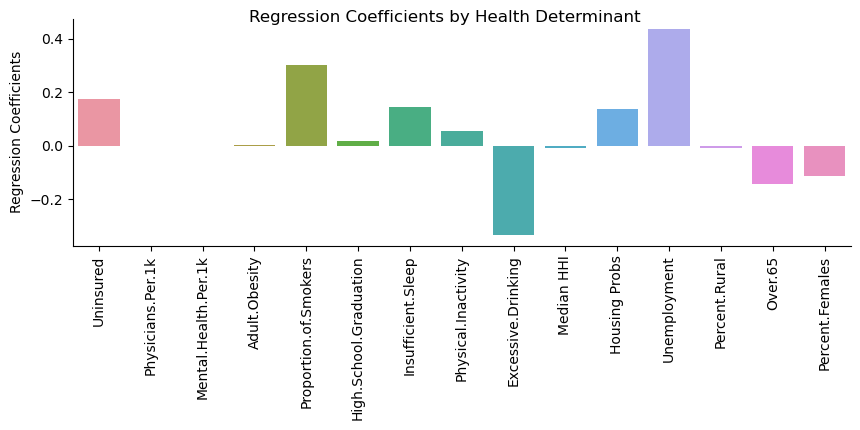

In [5]:
multi_coeffs_no_intercept = multi_coeffs.drop([0]); chart = sns.catplot(x='Health Determinant', y='Regression Coefficients', kind='bar', data=multi_coeffs_no_intercept, height=3, aspect=3);chart.set_xticklabels(rotation=90); chart.set_xlabels(""); chart.fig.suptitle('Regression Coefficients by Health Determinant'); plt.show()

###### Note, Median Household Coefficient shown per 10k of Income

Now, let's look at the States in order of health (by average Health Index of a state's counties, weighted by county population). We've also bucketed the data by region.

In [6]:
state_df = county_data
state_population = state_df.groupby('State.Abbreviation')['Population'].sum().reset_index()

state_df = state_df.merge(right=state_population, how='left', left_on='State.Abbreviation', right_on='State.Abbreviation')
state_df.rename(columns={'Population_x':'Population.County', 'Population_y':'Population.State'}, inplace=True)
state_df['Pop_Weight_Factor'] = state_df['Population.County'] / state_df['Population.State']
state_df['Poor.Health_Weighted'] = state_df['Poor.Health'] * (state_df['Pop_Weight_Factor'])
# state_df

In [7]:
states_health = state_df.groupby('State.Abbreviation')['Poor.Health_Weighted'].sum().reset_index()

In [8]:
NE = ['CT','ME','MA','NH','NJ','NY','PA','RI','VT','DE','MD','DC']
SE = ['AL','AR','FL','GA','KY','LA','MS','NC','SC','TN','VA','WV']
MW = ['IL','IN','IA','KS','MI','MN','MO','OH','ND','NE','SD','WI']
WE = ['CA','CO','ID','NV','MT','OR','UT','WA','WY']
SW = ['AZ','NM','OK','TX']
Other = ['AK', 'HI']

states_health['Region'] = np.nan
for i in range(len(states_health)):
    temp = ''
    if (states_health.loc[i,'State.Abbreviation'] in NE):
        temp = 'Northeast'
    elif (states_health.loc[i,'State.Abbreviation'] in SE):
        temp = 'Southeast'
    elif (states_health.loc[i,'State.Abbreviation'] in MW):
        temp = 'Midwest'
    elif (states_health.loc[i,'State.Abbreviation'] in SW):
        temp = 'Southwest'
    elif (states_health.loc[i,'State.Abbreviation'] in WE):
        temp = 'West'
    else:
        temp = 'Other'
    
    states_health.loc[i,'Region'] = temp
pass

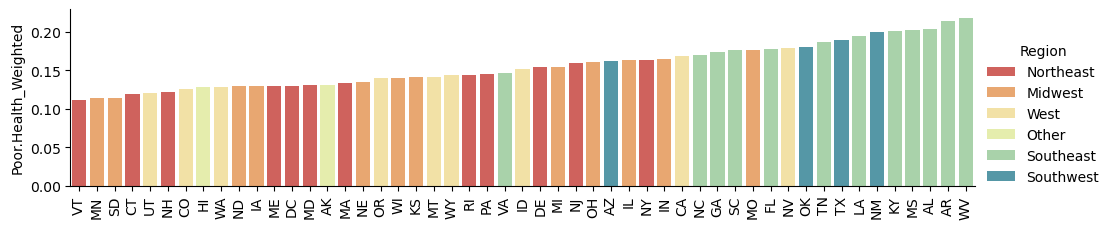

In [9]:
chart = sns.catplot(x='State.Abbreviation',y='Poor.Health_Weighted', hue='Region', kind='bar', palette='Spectral',dodge=False, data=states_health.sort_values(by='Poor.Health_Weighted'), height=2.5, aspect=4); chart.set_xlabels("");chart.set_xticklabels(rotation = 90); plt.show()

Eyeballing the chart, the unhealthiest states appear to generally be in the southeast and southwest, but otherwise there doesn't appear to be a clear trend by region.

The visualization by region led me to me second and third questions:
* Why are Southeast and Southwest less healthy than other regions?
* Are there differences in the most important determinants of health by region? For example, is unemployment a larger predictor of poor health if you live in the Northeast vs. the West?

# Goals
So, after performing a multivariable regression, analyzing the coefficient of certain x-variables, and determining the healthiest states and regions, we've identified three questions:
1. Why is Drinking negatively correlated with Poor Health?
2. Why are Southeast and Southwest less healthy than other regions?
3. Are there differences in the most important determinants of health by region?

Let's try and answer them!

# Q1: Why is Drinking negatively correlated with Poor Health?
* As a business school student, I enjoy a pint or two. I've been told ad nauseum that excessive drinking is bad for your health, so why does the data show a surprising negative correlation?
* It seems unlikely common knowledge and scientific consensus about excessive drinking is wrong, so what could it be? Let's dig in!

Just to confirm there wasn't something wonky with the multivariable regression, let's examine a linear regression comparing Excessive Drinking and Poor Health.

Clearly, there is indeed a negative relationship

In [10]:
county_data = county_data.merge(states_health, left_on='State.Abbreviation', right_on='State.Abbreviation')

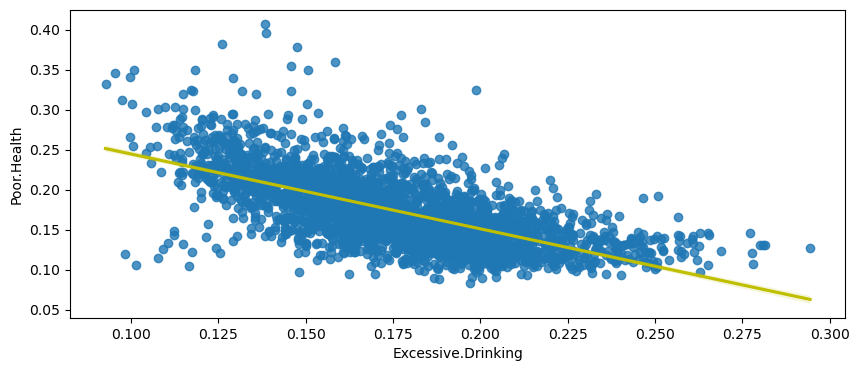

In [11]:
fig,ax = plt.subplots(); fig.set_size_inches(10,4); sns.regplot(x="Excessive.Drinking", y="Poor.Health", data=county_data, ax=ax, line_kws=dict(color='y')); plt.show()

###### Note: Regression coefficient of -0.935 (p-val = 0.000)

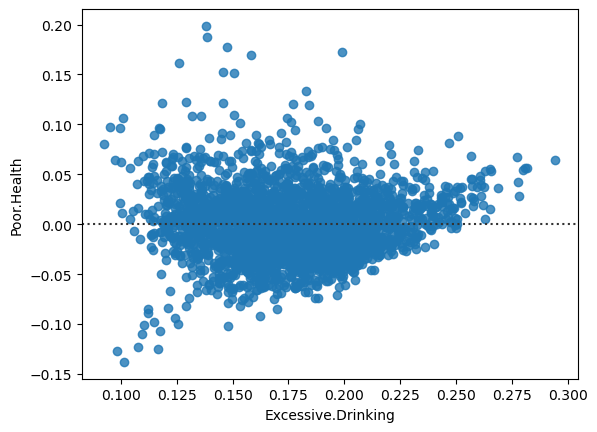

In [12]:
#Residuals plot
sns.residplot(x="Excessive.Drinking", y="Poor.Health", data=county_data); plt.show()

In [13]:
#Check regression
formula_string = 'Q("Poor.Health") ~ Q("Excessive.Drinking")'
ols_booze = smf.ols(formula=formula_string, data=county_data).fit()
# print(ols_booze.summary())

What's going on? Is common knowledge wrong, or is there something else going on here?

Let's look at correlations between Drinking and a few other X-variables that were positively correlated with Poor Health (see the multivariable regression in the Intro section), Proportion of Smokers and Unemployment. 

Drinking is also negatively correlated with these variables!

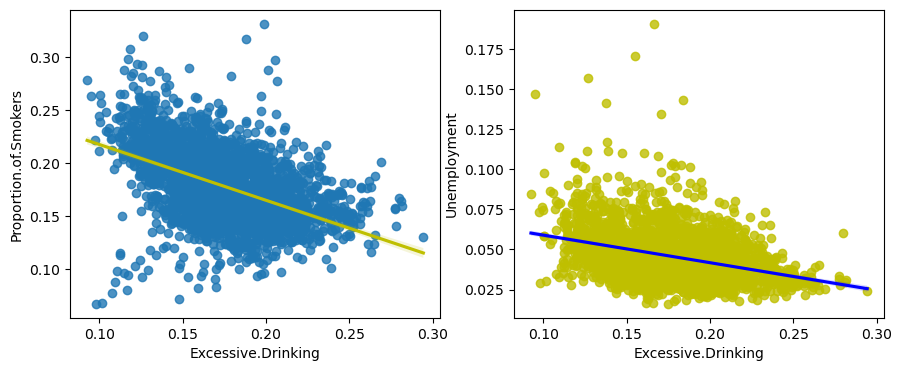

In [14]:
fig, axs = plt.subplots(ncols=2); fig.set_size_inches(10.5,4); sns.regplot(x="Excessive.Drinking", y="Proportion.of.Smokers", data=county_data, ax=axs[0], line_kws=dict(color='y')); sns.regplot(x="Excessive.Drinking", y="Unemployment", data=county_data, ax=axs[1], line_kws=dict(color='b'), scatter_kws=dict(color='y')); plt.show()

###### Note: Smokers regression coefficient of -0.523 (p-val = 0.000) and Unemployment coefficient of -0.172 (p-val = 0.000)

In [15]:
#Check the regressions
formula_string = 'Q("Proportion.of.Smokers") ~ Q("Excessive.Drinking")'
ols_booze = smf.ols(formula=formula_string, data=county_data).fit()
# print(ols_booze.summary())

In [16]:
formula_string = 'Q("Proportion.of.Smokers") ~ Q("Excessive.Drinking")'
ols_booze = smf.ols(formula=formula_string, data=county_data).fit()
# print(ols_booze.summary())

In [17]:
formula_string = 'Q("Poor.Health") ~ Q("Excessive.Drinking") + Q("Proportion.of.Smokers") + Q("Unemployment") + Q("Excessive.Drinking"):Q("Proportion.of.Smokers") + Q("Excessive.Drinking"):Q("Unemployment")'
ols_booze = smf.ols(formula=formula_string, data=county_data).fit()
print(ols_booze.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("Poor.Health")   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1265.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:27:44   Log-Likelihood:                 6191.9
No. Observations:                2715   AIC:                        -1.237e+04
Df Residuals:                    2709   BIC:                        -1.234e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Can the negative correlation between Drinking and Poor Health be explained by Drinking's interaction with Smoking and Unemployment? Let's look at the numbers:

```
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0411      0.013      3.068      0.002       0.015       0.067
Excessive.Drinking     0.0130      0.077      0.169      0.866      -0.138       0.164
Proportion.of.Smokers  0.8393      0.087      9.604      0.000       0.668       1.011
Unemployment           1.5991      0.193      8.306      0.000       1.222       1.977
Drinking:Smokers      -1.5686      0.523     -3.000      0.003      -2.594      -0.544
Drinking:Unemployment -5.6071      1.139     -4.921      0.000      -7.841      -3.373
======================================================================================
```

The numbers seem to indicate yes! If you include Smokers and Unemployment in a multivariable regression, and adjust for the interaction between Drinking and Smoking / Drinking and Unemployment, Drinking's coefficient is near zero. i.e. this analysis appears to indicate Drinking does not impact Health!

Given the finding, is it time to go hit the bar? As we'll see in a subsequent section, not quite yet...

# Q2: Why are the Southeast and Southwest less healthy than other Regions?
* The top 5 unhealthiest states are all in the Southeast, and the top 10 are all in the Southeast or Southwest
* 14 of the top 16 unhealthiest states are in the Southeast or Southwest, and the healthiest state in these regions is Virginia, at 25th overall
* What are Southerners doing that makes them so much less healthy?

In the Southeast, one big reason jumps out quickly: they smoke more. A lot more!

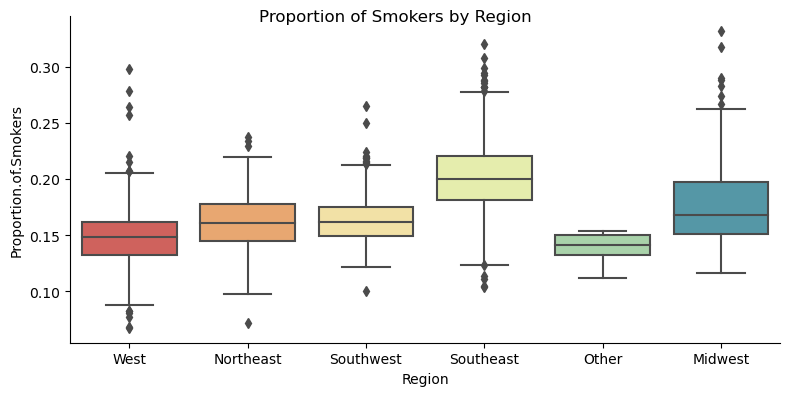

In [18]:
chart = sns.catplot(data=county_data.sort_values(by='Proportion.of.Smokers'), kind='box', dodge=False, x='Region', y='Proportion.of.Smokers', palette = 'Spectral', height=4,aspect=2); chart.fig.suptitle('Proportion of Smokers by Region');plt.show()

In [19]:
region_group = county_data.groupby('Region')['Proportion.of.Smokers'].mean().reset_index()
region_group.rename(columns={'Proportion.of.Smokers':'Proportion.of.Smokers_Mean'}, inplace=True)
region_group['Proportion.of.Smokers_Median'] = county_data.groupby('Region')['Proportion.of.Smokers'].median().reset_index()['Proportion.of.Smokers']
region_group['Proportion.of.Smokers_Median'] = round(region_group['Proportion.of.Smokers_Median'],4)
region_group['Proportion.of.Smokers_Mean'] = round(region_group['Proportion.of.Smokers_Mean'],4)
region_group = region_group.sort_values(by='Proportion.of.Smokers_Mean', ascending=False)
# region_group

As shown previously, smoking is one of largest predictors of Poor Health. The average county in the Southeast has 20% smokers, nearly 2.5% above the next closest region. There are likely other factors at play as well, but this is a big difference!

So the Southeast's poor health seems to be driven in part by a higher rate of smokers. But what about the Southwest? This region has worse health performance, but has a rate of smoking in-line with other geographies that are healthier. What could be driving the poor health? Let's take a look at some other factors and see if that tells us more

In [20]:
mean_group = county_data.groupby('Region').mean()
to_plot = mean_group[['Proportion.of.Smokers','Uninsured', 'Adult.Obesity', 'Insufficient.Sleep', 'Physical.Inactivity', 'Excessive.Drinking', 'Severe.Housing.Problems','Unemployment']]
# to_plot = mean_group.drop(labels=['Five-digit.FIPS.Code', 'State.FIPS.Code', 'County.FIPS.Code', 'Poor.Health', 'Population', 'Median.Household.Income', 'Life.Expectancy'], axis=1)
to_plot = to_plot.reset_index()
to_plot = to_plot.melt(id_vars=['Region'], value_vars=['Proportion.of.Smokers', 'Uninsured', 'Adult.Obesity', 'Insufficient.Sleep', 'Physical.Inactivity', 'Excessive.Drinking', 'Severe.Housing.Problems','Unemployment'])

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/2811053158.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_group = county_data.groupby('Region').mean()


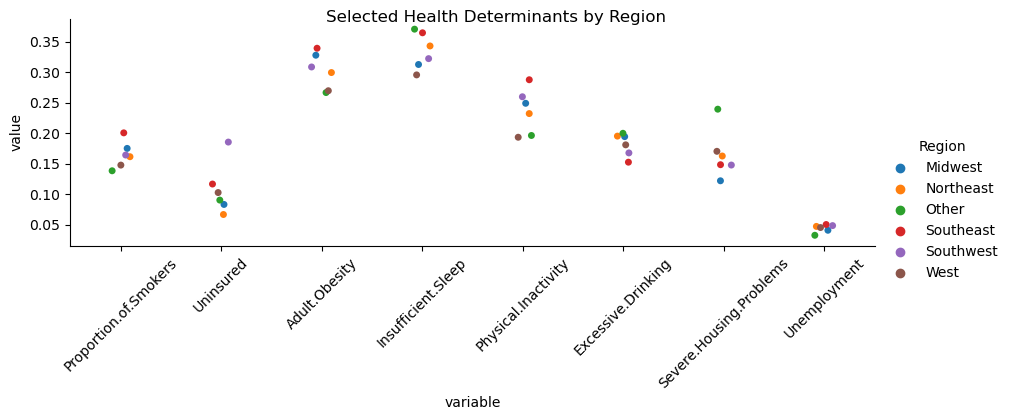

In [21]:
chart = sns.catplot(data=to_plot, dodge=False, y='value', x = 'variable', hue = 'Region', height=3,aspect=3);chart.set_xticklabels(rotation=45);chart.fig.suptitle('Selected Health Determinants by Region');plt.show()

Nothing seems to jump out; the Southwest, on average, has less folks insured, which could be a driver, but the answer isn't clear! (Also note, the Southeast scores poorly relative to other regions for many of these metrics, which also could explain its higher Poor Health)

Checking out each x-variable would take a while. Further, we haven't even begun to look in detail at categorical variables, or even all continuous variables (e.g. income) yet! So, perhaps a tree-based approach can help us find out more

Let's binarize the categorical variables and see what the tree says are the most important predictors of Poor Health...

In [22]:
from sklearn import tree

In [23]:
Xcts = county_data.drop(columns=['Food.Insecurity.Quintile','Income.Inequality.Quartile', 'Five-digit.FIPS.Code', 'State.FIPS.Code', 'County.FIPS.Code', 'State.Abbreviation', 'CountyName','Election.Results.2016','Region','Poor.Health','Poor.Health_Weighted','Life.Expectancy'])
Xcat = county_data[['Food.Insecurity.Quintile','Income.Inequality.Quartile','Election.Results.2016']]
temp = pd.get_dummies(Xcat)
X = Xcts.merge(temp, left_index=True, right_index=True)
# X

In [24]:
y = county_data['Poor.Health']

In [25]:
regtree = tree.DecisionTreeRegressor(max_leaf_nodes = 10)
regtree.fit(X, y)

plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

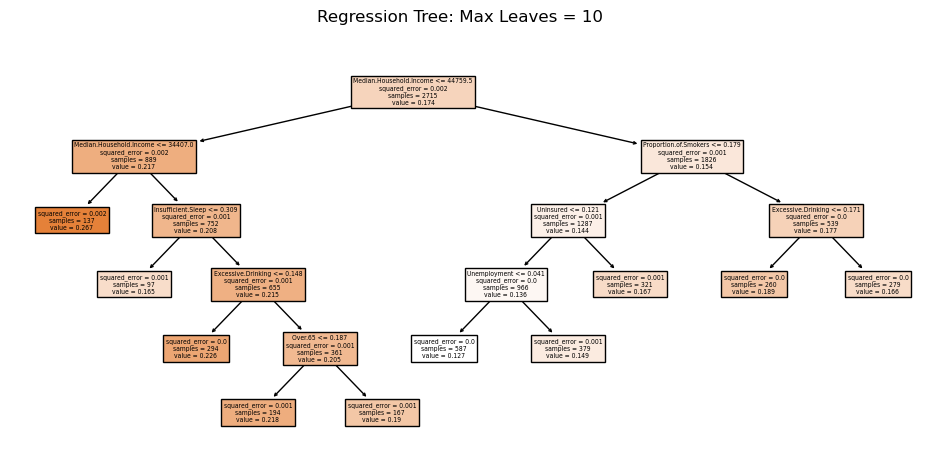

In [26]:
plt.figure(figsize=(12,5)); plt.suptitle("Regression Tree: Max Leaves = 10");tree.plot_tree(regtree, filled=True, feature_names=X.columns.to_list());

Summarizing the tree, it seems there are a few factors that predict Poor Health, with Median Household Income being a highly important variable (and one we did not look at earlier!)
To get more detailed, let's take a look at the variable importances:

In [27]:
importances = pd.DataFrame({'Feature': X.columns, 'Importance': np.round(regtree.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False)

In [28]:
importances.head(7)

,Feature,Importance
9,Median.Household.Income,0.701
4,Proportion.of.Smokers,0.107
0,Uninsured,0.058
6,Insufficient.Sleep,0.052
8,Excessive.Drinking,0.035
11,Unemployment,0.028
13,Over.65,0.018


The tree indicates that Median Household Income is by far and away the most important predictor of Poor Health, although there are other variables that do have some effect (e.g. Smoking). In fact, the root of the tree splits on an MMHI of ~45k, and looking at the leaves, counties with MMHI >45k are nearly all predicted to have better Health than those with <45k, regardless of other factors!

So, with this new knowledge from our tree, let's take a look at Median Household Income by Region

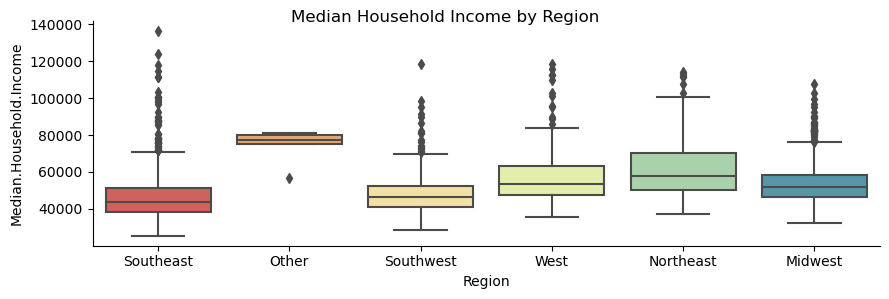

In [29]:
chart = sns.catplot(data=county_data, kind='box', dodge=False, x='Region', y='Median.Household.Income', palette = 'Spectral', height=3,aspect=3); chart.fig.suptitle('Median Household Income by Region');plt.show()

This seems to give us an answer! The Southwest has lower Median Household Income than other regions, specifically more counties with MMHI <45k, which, if the tree is accurate, seems to be what's driving their relative poor health.

This also provides additional clarity around the Southeast as well -- in addition to the other factors (higher smoking, obesity, etc.), the Southeast also has lower household incomes, which appears to be a large reason why it has worse Health overall!

In addition, our finding regarding Median Household Income warrants us revisiting Question 1 ("Why is Drinking negatively correlated with Poor Health").

We initially concluded it is because Drinking is negatively correlated with Smoking, but is that the full story?

It doesn't look like it!

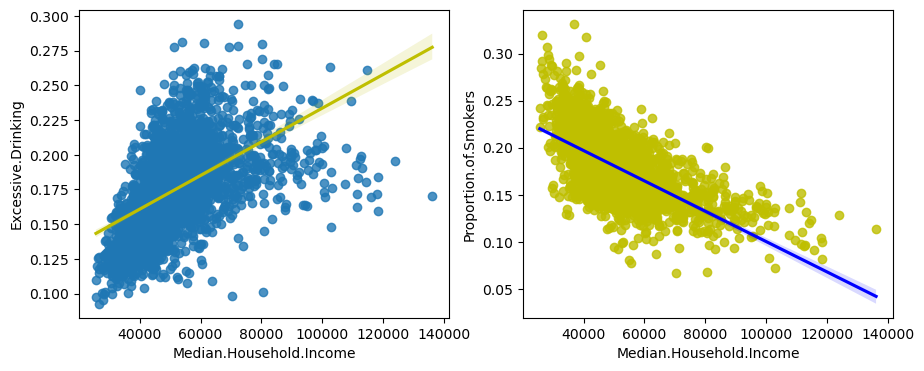

In [30]:
fig, axs = plt.subplots(ncols=2); fig.set_size_inches(10.5,4); sns.regplot(x="Median.Household.Income", y="Excessive.Drinking", data=county_data, ax=axs[0], line_kws=dict(color='y')); sns.regplot(x="Median.Household.Income", y="Proportion.of.Smokers", data=county_data, ax=axs[1], line_kws=dict(color='b'), scatter_kws=dict(color='y')); plt.show()

Median Household Income is positively correlated with Excessively Drinking, but negatively correlated with Proportion of Smokers. So perhaps the real answer is that individuals who drink more are wealthier, and the positive effects from higher household income more than offset the negative effects of drinking!

However, one caveat: even when looking using a tree-based approach, Excessive Drinking still has a moderate negative impact on Poor Health (the nodes to the right of any nodes where Excessive Drinking is the splittor have higher Poor Health values than those to the left)!

However, this is a bit outside the scope of this exercise, so we can leave this as area for further exploration.

# Q3: Are there differences in Determinants of Health by Region?
* We've already seen that there are meaningful regional differences in smoking, drinking, obesity, household income, which in turn are driving differences in the rate of Poor Health
* But is the impact of these factors the same across regions?
    * For example, all else equal, is smoking a better predictor of Poor Health in the Southeast vs. the Northeast, or is it relatively consistent?
* A tree-based model seems logical here; let's run a tree for each region (excl. AK/HI) and see what comes out!

In [31]:
#make dataframes for each region
X['Region'] = county_data['Region']

X_NE = X[X['Region'] == 'Northeast'] 
y_NE = county_data[county_data['Region'] == 'Northeast']['Poor.Health']

X_SE = X[X['Region'] == 'Southeast'] 
y_SE = county_data[county_data['Region'] == 'Southeast']['Poor.Health']

X_SW = X[X['Region'] == 'Southwest'] 
y_SW = county_data[county_data['Region'] == 'Southwest']['Poor.Health']

X_WE = X[X['Region'] == 'West'] 
y_WE = county_data[county_data['Region'] == 'West']['Poor.Health']

X_MW = X[X['Region'] == 'Midwest'] 
y_MW = county_data[county_data['Region'] == 'Midwest']['Poor.Health']

X_regions_list = [X_NE, X_SE, X_SW, X_WE, X_MW]
y_regions_list = [y_NE, y_SE, y_SW, y_WE, y_MW]

for region in X_regions_list:
    region.drop(labels='Region', axis=1, inplace=True)

X.drop('Region', axis=1, inplace=True)

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/1544404937.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region.drop(labels='Region', axis=1, inplace=True)
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/1544404937.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region.drop(labels='Region', axis=1, inplace=True)
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/1544404937.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

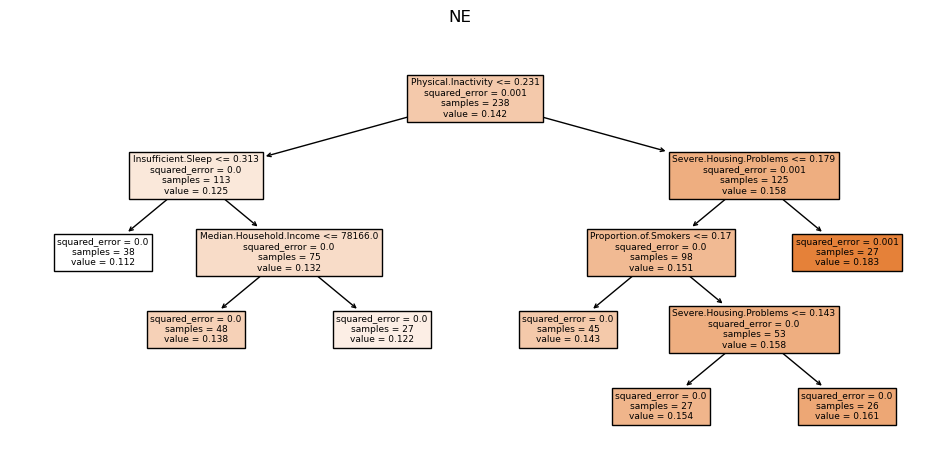

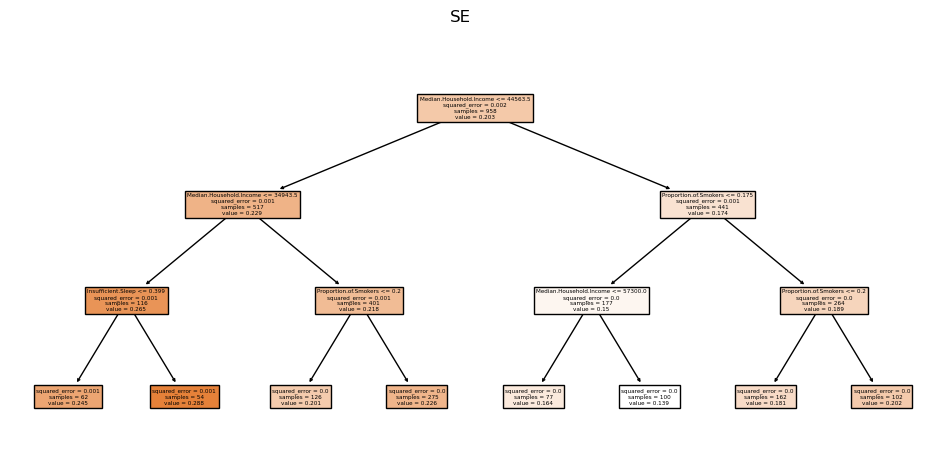

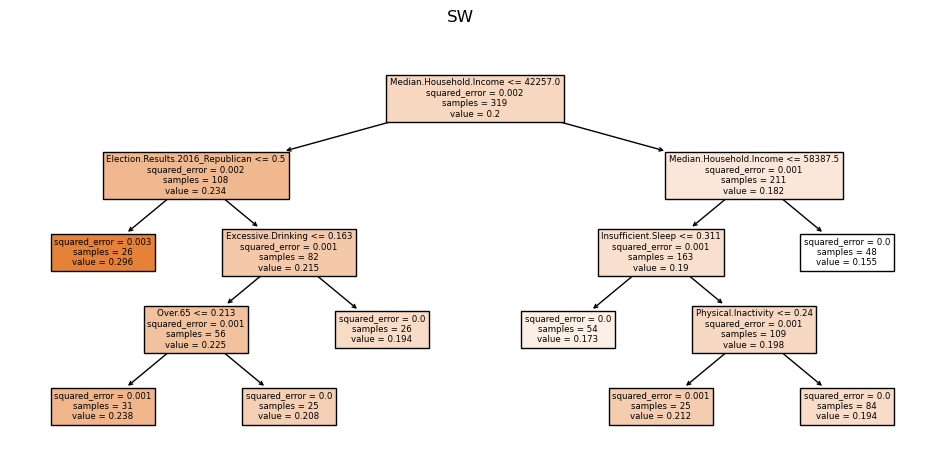

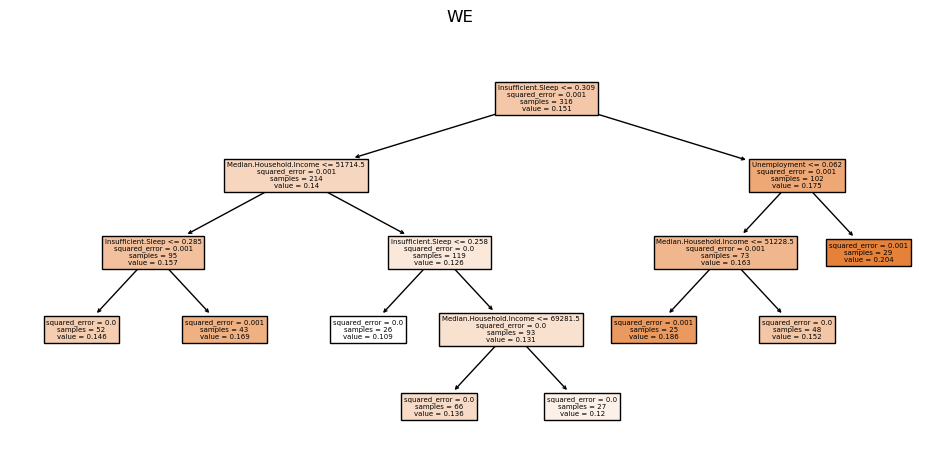

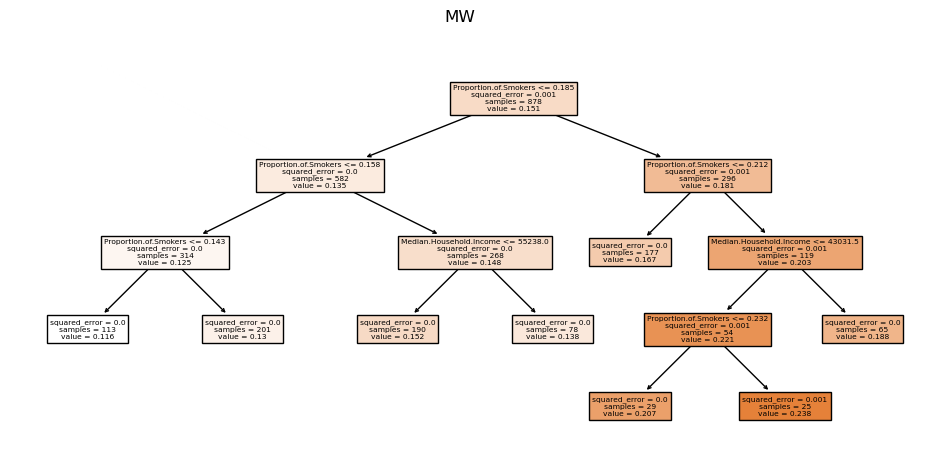

In [32]:
#make the trees for each region
max_leaf_value = 8
min_samples_value = 25
regtree_NE = tree.DecisionTreeRegressor
regtree_SE = tree.DecisionTreeRegressor
regtree_SW = tree.DecisionTreeRegressor
regtree_WE = tree.DecisionTreeRegressor
regtree_MW = tree.DecisionTreeRegressor

tree_regions_list = [regtree_NE, regtree_SE, regtree_SW, regtree_WE, regtree_MW]
title_list = ['NE', 'SE', 'SW', 'WE', 'MW']

importances_region = pd.DataFrame({'Feature': X.columns, 'Mean_All_Regions' : np.nan, 'Median_All_Regions' : np.nan})

#plot the trees for each region
#store variable importances in a dataframe
for i, tree_region in enumerate(tree_regions_list):
    tree_region = tree.DecisionTreeRegressor(min_samples_leaf = min_samples_value, max_leaf_nodes = max_leaf_value)
    tree_region.fit(X_regions_list[i], y_regions_list[i])
    
    to_add = "Importance_"+title_list[i]
    importances_region[to_add] = np.round(tree_region.feature_importances_,3)
     
    plt.figure(figsize=(12,5))
    plt.suptitle(title_list[i])
    tree.plot_tree(tree_region, filled=True, feature_names=X_regions_list[i].columns.to_list());

Rather than showing a graph of each tree (see the Jupyter Notebook for that!), I've displayed the most important variables for each region.

In [33]:
importances_region = importances_region[(importances_region['Importance_NE'] != 0)
                                        | (importances_region['Importance_SE'] != 0)
                                        | (importances_region['Importance_SW'] != 0)
                                        | (importances_region['Importance_WE'] != 0)
                                        | (importances_region['Importance_MW'] != 0)
                                       ]
importances_region['Median_All_Regions'] = importances_region.median(axis=1)
importances_region['Mean_All_Regions'] = np.round(importances_region.mean(axis=1),3)
importances_region = importances_region.sort_values('Mean_All_Regions', ascending=False)

/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/3291007703.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  importances_region['Median_All_Regions'] = importances_region.median(axis=1)
/var/folders/8k/y1_fdgbj36d996kdx82hx5j00000gn/T/ipykernel_27766/3291007703.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  importances_region['Mean_All_Regions'] = np.round(importances_region.mean(axis=1),3)


In [34]:
importances_region

,Feature,Mean_All_Regions,Median_All_Regions,Importance_NE,Importance_SE,Importance_SW,Importance_WE,Importance_MW
9,Median.Household.Income,0.352,0.338,0.043,0.762,0.564,0.338,0.068
4,Proportion.of.Smokers,0.206,0.053,0.053,0.196,0.000,0.000,0.932
6,Insufficient.Sleep,0.124,0.055,0.094,0.042,0.055,0.501,0.000
7,Physical.Inactivity,0.101,0.000,0.593,0.000,0.014,0.000,0.000
26,Election.Results.2016_Republican,0.050,0.000,0.000,0.000,0.299,0.000,0.000
10,Severe.Housing.Problems,0.036,0.000,0.218,0.000,0.000,0.000,0.000
11,Unemployment,0.027,0.000,0.000,0.000,0.000,0.161,0.000
8,Excessive.Drinking,0.006,0.000,0.000,0.000,0.039,0.000,0.000
13,Over.65,0.005,0.000,0.000,0.000,0.029,0.000,0.000


Generally, we see the same variables here as with our tree built in Question 2. However, there appears to be significant regional variation in feature importance; for example, the Northeast and Midwest have low importance ascribed to Median Household Income. The West's most important factor is Insufficient Sleep. What could be the reason?

###### Note, Tree constructed with min sample size of 25 or max leaves of 8

Let's refresh the work we did in question 2, and take a look at household incomes by region:

In [35]:
region_list = ['Northeast', 'Southeast', 'Southwest', 'West', 'Midwest']
region_df = county_data[county_data['Region'] == 'Northeast']['Median.Household.Income'].describe().reset_index()

for i, region in enumerate(region_list):
    col_string = "MMHI_" + title_list[i]
    region_df[col_string] = round(county_data[county_data['Region'] == region]['Median.Household.Income'].describe().reset_index()['Median.Household.Income'])

region_df = region_df.drop("Median.Household.Income", axis=1)
region_df = region_df.drop([0,2])

In [36]:
region_df

,index,MMHI_NE,MMHI_SE,MMHI_SW,MMHI_WE,MMHI_MW
1,mean,62231.0,46594.0,48203.0,56932.0,53359.0
3,min,37377.0,25569.0,28377.0,35725.0,32224.0
4,25%,50036.0,38312.0,40891.0,47769.0,46516.0
5,50%,57650.0,43920.0,46378.0,53459.0,51892.0
6,75%,70427.0,51384.0,52468.0,63004.0,58374.0
7,max,114269.0,136191.0,118380.0,118468.0,107676.0


The Northeast, West, and Midwest have significantly higher Median Household Incomes than the Southeast and Southwest. In fact, the 25th percentile county in the Northeast is nearly as wealthy as the 75th percentile counties in the Southeast and Southwest!

Now, recall our tree from Question 2. The most important factor (by far) in determining poor health was Median Household Income. The root node of the tree split on Median Household Income of ~45k. If MMHI was <= 45k, then the next split was on an MMHI 35k!

However, if MMHI was >45k, then subsequent splits were on different factors: smoking, unemployment, etc.

So a logical, although certainly not the only, explanation is that MMHI matters a lot in determining health up to a certain level of income (~45k or so), then other factors become more important in predicting Poor Health.

So that could explain why the trees for the Northeast, Midwest, and West have different factors of importance. These regions are generally wealthier -- in fact the 25th percentile county in these regions is above the ~45k MMHI that was the split of the initial tree -- and so MMHI may matter less as a predictor relative to others!

Let's take a quick look to see if that interpretation is consistent with the data

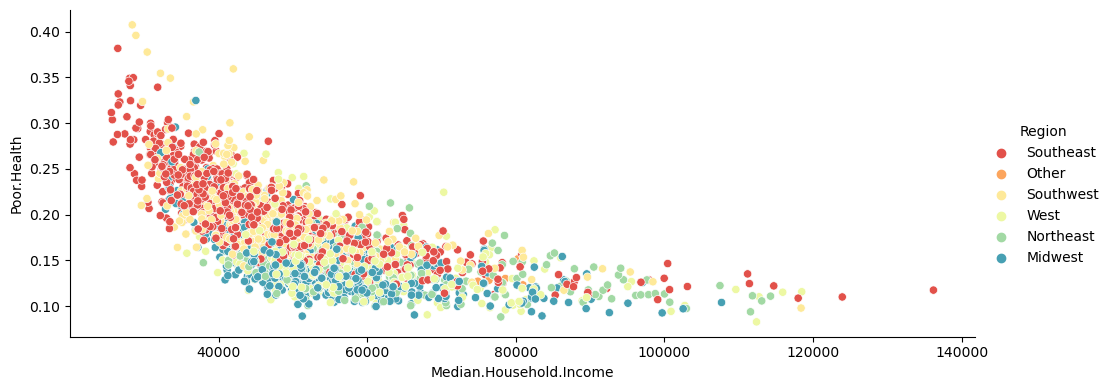

In [37]:
sns.relplot(data=county_data, hue='Region', x='Median.Household.Income', y='Poor.Health', palette='Spectral', height=4, aspect=2.5); plt.show()

It does seem like the rates of Poor Health level off above a certain income point in the 45-55k range!

# Conclusion
We set out to answer three questions:

Q1: Why is Excessive Drinking negatively correlated with Poor Health?
* Initially, we concluded that it was because Drinkers were less likely to Smoke, and the negative effect of Smoking outweighed the negative effects of Drinking, but this only turned out to be part of the story
* Based on our tree-based analysis, it also seems likely that this relationship is driven by Income - specifically, Higher Income Households drink more (and smoke less), and High Income is negatively correlated with Poor Health!
* So, the reason for the negative correlation between Drinking and Poor Health may be a bit of both of the above; Excessive Drinkers are less likely to Smoke, and are on average Wealthier!



###### cont'd

# Conclusion (cont'd)
Q2: Why are the Southeast and Southwest less healthy?
* Initially, we concluded the Southeast had a higher percentage of smokers than other regions (and generally elevated other health risks, such as obesity), which drove worse health outcomes
* The reasons for Southwest's relative poor health was less clear
* However, after a tree-based analysis, we discovered the importance of Median Household Income as a factor in predicting Poor Health
    * Both the Southeast and Southwest had more lower-income counties than other regions (below the 45k and 35k split points in the tree), which could be the primary reason their overall health is worse!



###### cont'd

# Conclusion (cont'd)
Q3: Are there differences in Determinants of Health by Region?
* A tree-based analysis indicated yes
    * Although, in aggregate the same important factors appeared at both the regional and national levels, most notably Median Household Income, there was significant variation in what factors were important at the regional level
* Specifically, the Northeast, Midwest, and West all had less importance ascribed to Household Income than other factors
    * A possible explanation is that the impact of Household Income on Poor Health levels off at an income level somewhere in the neighborhood of 45-50k, consistent with the findings from our national tree
    * This phenomenon could explain why the trees for the Northeast, Midwest, and West have different important x-variables; counties in these regions are generally at or above ~50k Median Household Income, so other factors are more important in determining health!

# Thank You!